In [ ]:
# !uv sync --all-extras

In [20]:
%load_ext autoreload
%autoreload 2

import os
import fsspec
import cryogrid_pytools as cg
import numpy as np
import xarray as xr
from cryogrid_pytools import data
from cryogrid_pytools import viz

os.environ['AWS_DEFAULT_PROFILE'] = 'pamir'  # for S3 bucket access

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [124]:
url = "simplecache::s3://spi-pamir-public/CryoGrid_pyTools-demo_data/pamir-N180-k1500-m7_70001_20101231.mat"

fname = fsspec.open_local(url, cache_storage="./data/cache/", same_names=True)

# Reading CryoGrid output

Currently only support for `read_OUT_regridded_FCI2`

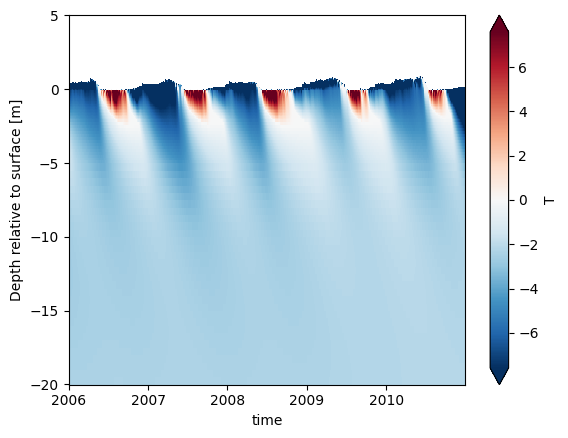

In [3]:
ds_profile = cg.read_OUT_regridded_file(
    fname, 
    deepest_point=-20,  # not required for a single file - will not return depth if not given
)  
# output dims are [time, level]

# since deepest_point is provided above, we can set depth as a dim instead of level
ds_profile = ds_profile.swap_dims(level='depth')  # the same can be done for elevation
ds_profile.T.plot(robust=True)


In [125]:
urls = "simplecache::s3://spi-pamir-public/CryoGrid_pyTools-demo_data/pamir-N180-k1500-m7_70001_*.mat"
fname_profiles = fsspec.open_local(urls, cache_storage="./data/cache/", same_names=True)

# when reading multiple files, deepest_point is required since multiple 
out = cg.read_OUT_regridded_files(fname_profiles, deepest_point=-20)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 2 out of 5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 5 out of 5 | elapsed:    0.5s finished


In [126]:
da = out.T[0].assign_attrs(long_name='Temperature', units='°C').compute()

In [127]:
ds = cg.analyze_profile(da)

Text(0.5, 1.0, '')

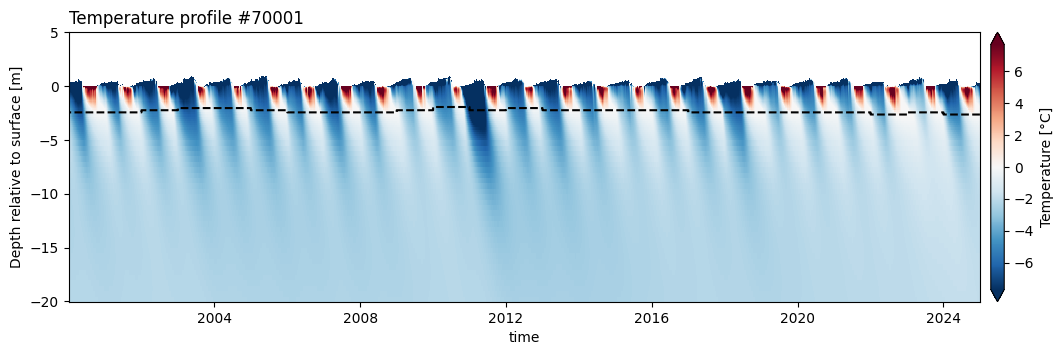

In [128]:
img = viz.plot_profile(ds.ground_temperature)
ds.ground_thermal_state.plot.contour(levels=[0.5, 1.5, 2.5], colors='k', ax=img.axes, linestyles='--')
img.axes.set_title('')

# Reading struct files from MATLAB


Note that `run_info.mat` cannot be read as it contains special classes that are not supported by `scipy.io.loadmat`.  

To save parts of `run_info`, use the following code in MATLAB:

<div style="background-color: #def0da; color: #64946D; padding: 16px 24px;">
 <div style="font-size: 16px; font-weight: bold;">ⓘ Tip for spatial data </div>
 <div style="font-size: 12px">
 To get spatial data from MATLAB, you need to save the data as shown in the code block below. The rest of the example in this code relies on this. 
 </div>
</div>

```matlab
run_info_spatial = run_info.SPATIAL.STATVAR
save "run_info_spatial.mat" run_info_spatial
```

In [246]:
import cryogrid_pytools.viz as viz
import rioxarray as rxr

fname_spatial = "simplecache::s3://spi-pamir-public/CryoGrid_pyTools-demo_data/run_spatial_info.mat"
fname_spatial = fsspec.open_local(fname_spatial, cache_storage="./data/cache/", same_names=True)

fname_dem = "simplecache::s3://spi-pamir-public/CryoGrid_pyTools-demo_data/elevation.tif"
fname_dem = fsspec.open_local(fname_dem, cache_storage="./data/cache/", same_names=True)

# read in the spatial data 
ds_spatial = cg.read_mat_struct_as_dataset(
    fname_spatial, 
    index=['coord_y', 'coord_x'],  # set the index to the spatial coordinates - this maps the data to 2D
    drop_keys=['cluster_idx'],  # the cluster_idx is not the same size as the other data, so we drop it, but its added as a coordinate
)

# we have to assign a CRS to the spatial data. The DEM is used as a reference
crs = rxr.open_rasterio(fname_dem).rio.crs
# now we can write the CRS to the spatial data (this is important for plotting later on)
ds_spatial = (
    ds_spatial
    .rename(coord_y='y', coord_x='x')  # rioxarray expects the coordinates to be named x and y
    .rio.write_crs(crs)  # and set the CRS
)

In [240]:
ds_flat = cg.read_mat_struct_as_dataset(
    fname_spatial,  # when leaving out the index, the data is kept in its flat shape
    drop_keys=['cluster_idx'])  
# the mask removes all points that are not a cluster centroid
cluster_centroids = ds_flat.index.isin(ds_flat.cluster_idx)

gdf_locations = viz.gridpoints_to_geodataframe(ds_flat.sel(index=cluster_centroids))

### Plotting data on interactive map

We can use `folium` to plot the data on an interactive map.

In the `viz` module, there are some functions to help with this. The `plot_map` function automatically plots the data to a `folium` map. 

/Users/luke/Work/PAMIR/CryoGrid-pyTools/.venv/lib/python3.10/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)



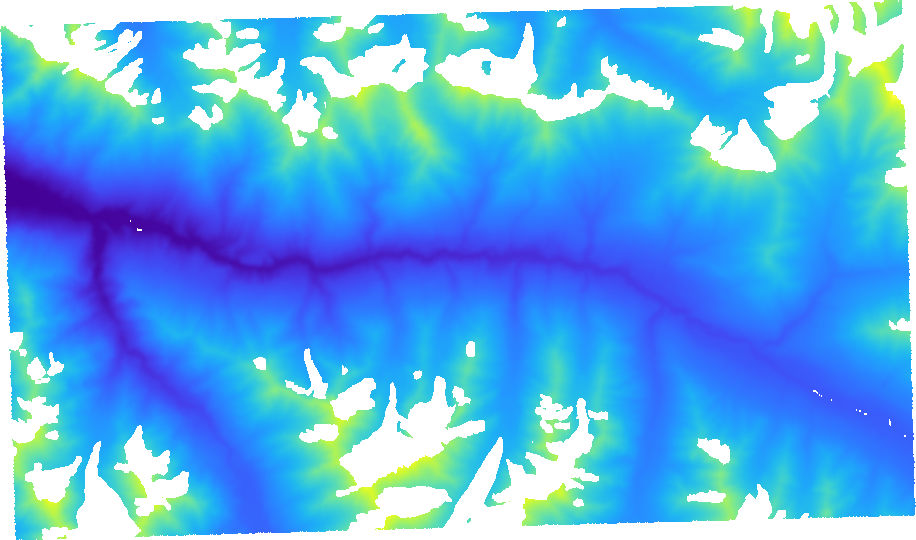

In [131]:
m = viz.plot_folium_map(ds_spatial.stratigraphy_index)
m = viz.plot_folium_map(ds_spatial.elevation, m=m)
m = gdf_locations.explore(m=m, name='Sample locations', **viz.MARKER_STYLES.blue_circle)
m = viz.finalize_folium_map(m)
m

# Mapping profile metrics to spatial maps

In [247]:
import cryogrid_pytools.viz as viz
import rioxarray as rxr
import pandas as pd

In [265]:
# this data has already been combined into a zarr file that can be accessed directly from S3
url_profiles = "s3://spi-pamir-public/CryoGrid_pyTools-demo_data/pamir-N180-k1500-m7_T_avg_2000_2023.zarr/"
ds_profiles = xr.open_zarr(url_profiles)
temp_profile_mean = ds_profiles.T_avg_2000_2023

In [266]:
temp_2m_mean = (
    temp_profile_mean
    .sel(depth=-2, method='nearest')  # select the temperature at 2m depth (or the nearest depth)
    .drop_vars(['depth'])  # drop the depth and elevation coordinates
    .assign_attrs(long_name='2 m ground temperature', units='°C')  # assign attributes to the data (for plotting)
    .compute())  # load the data into memory

In [267]:
# preparing cluster mapping
# first, get the flattened index of the cluster centroids, stored in the cluster order
cluster_centroid_index = ds_spatial.cluster_idx.copy(deep=True).to_series()
# assign a new index starting from 1 to the number of clusters
cluster_centroid_index.values[:] = range(1, ds_spatial.cluster_idx.size+1)
# create a new index for the temperature data, mapping the original index to the cluster index
new_index = temp_2m_mean.index.to_series().map(cluster_centroid_index)
# now, temp_2m_mean has a new index that corresponds to the cluster numbers
temp_2m_mean = temp_2m_mean.assign_coords(index=new_index)

Text(0.0, 1.0, 'CryoGrid mean temperature 1975-1979 for Abramov region')

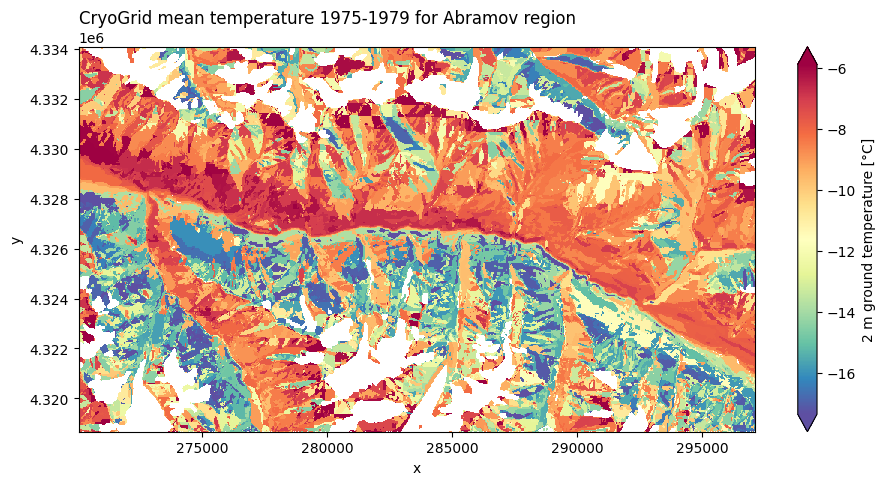

In [269]:
temp_2m_mapped = cg.spatial_clusters.map_gridcells_to_clusters(
    temp_2m_mean, 
    ds_spatial.cluster_num)

img = temp_2m_mapped.plot.imshow(robust=True, aspect=2.2, size=5, cmap='Spectral_r')
img.axes.set_aspect('equal')
img.axes.set_title('', loc='center')
img.axes.set_title('CryoGrid mean temperature 1975-1979 for Abramov region', loc='left')

# img.figure.savefig('./docs/imgs/mapped_temp_2m-1975_1979.png', dpi=150, bbox_inches='tight')

# Reading Excel config files

This is experimental. Could be used to run checks on files, and configurations for the model.

In [270]:
url_excel = 'simplecache::s3://spi-pamir-public/CryoGrid_pyTools-demo_data/kaindy-7234w3899s7265e3913n-smpl0.xlsx'
fname_excel = fsspec.open_local(url_excel, cache_storage="./data/cache/", same_names=True)

config = cg.CryoGridConfigExcel(fname_excel)

2025-10-07 16:44:31.024 | WARNING  | cryogrid_pytools.excel_config._get_root_path:100 | Could not find root path. Set to current directory. You can change this manually with excel_config.root = pathlib.Path('/path/to/root')
2025-10-07 16:44:31.110 | SUCCESS  | cryogrid_pytools.excel_config.__init__:39 | Loaded CryoGrid Excel configuration file: /Users/luke/Work/PAMIR/CryoGrid-pyTools/data/cache/kaindy-7234w3899s7265e3913n-smpl0.xlsx
2025-10-07 16:44:31.125 | WARNING  | cryogrid_pytools.excel_config.check_files_exist:462 | Cannot find file: /Users/luke/Work/PAMIR/CryoGrid-pyTools/forcing/era5.mat
2025-10-07 16:44:31.126 | WARNING  | cryogrid_pytools.excel_config.check_files_exist:462 | Cannot find file: /Users/luke/Work/PAMIR/CryoGrid-pyTools/forcing/elevation.tif
2025-10-07 16:44:31.146 | SUCCESS  | cryogrid_pytools.excel_config.check_strat_layers:448 | [STRAT_layers_1]  parameters passed checks
2025-10-07 16:44:31.147 | SUCCESS  | cryogrid_pytools.excel_config.check_strat_layers:448 |

In [107]:
deepest_point = -config.get_output_max_depth(depth_key='lower_elevation')  # this can be used to find the maximum depth of the output
cg.read_OUT_regridded_files(fname_profiles, deepest_point=deepest_point)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 2 out of 5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 5 out of 5 | elapsed:    0.5s finished


<xarray.Dataset> Size: 293MB
Dimensions:       (profile: 1, depth: 501, time: 36528)
Coordinates:
  * profile       (profile) int64 8B 70001
  * time          (time) datetime64[ns] 292kB 2000-01-01T06:00:00 ... 2024-12-31
  * depth         (depth) float64 4kB 5.0 4.95 4.9 4.85 ... -19.9 -19.95 -20.0
Data variables:
    T             (profile, depth, time) float32 73MB dask.array<chunksize=(1, 501, 8764), meta=np.ndarray>
    water         (profile, depth, time) float32 73MB dask.array<chunksize=(1, 501, 8764), meta=np.ndarray>
    ice           (profile, depth, time) float32 73MB dask.array<chunksize=(1, 501, 8764), meta=np.ndarray>
    class_number  (profile, depth, time) float32 73MB dask.array<chunksize=(1, 501, 8764), meta=np.ndarray>
    elevation     (depth) float32 2kB dask.array<chunksize=(501,), meta=np.ndarray>

# Reading ERA5 forcing data

<div style="background-color: #fcf8e5; color: #8C6D46; padding: 16px 24px;">
 <div style="font-size: 16px; font-weight: bold;">⚠ Warning</div>
 <div style="font-size: 12px">
 This is currently still in development. 
 </div>
</div>

In [117]:
fname = '../cryogrid-run-manager/forcing/era5-pamirs-1990_2024.mat'
ds = cg.forcing.read_mat_ear5(fname)
ds

<xarray.Dataset> Size: 12GB
Dimensions:  (lon: 17, lat: 17, level: 8, time: 102272)
Coordinates:
  * lon      (lon) float32 68B 71.0 71.25 71.5 71.75 ... 74.25 74.5 74.75 75.0
  * lat      (lat) float32 68B 40.0 39.75 39.5 39.25 ... 36.75 36.5 36.25 36.0
  * level    (level) int64 64B 300 500 600 700 800 850 900 1000
  * time     (time) datetime64[ns] 818kB 1990-01-01 ... 2024-12-31T21:00:00
Data variables: (12/21)
    Zs       (time, lat, lon) float64 236MB 1.528e+03 1.883e+03 ... 4.56e+03
    u10      (time, lat, lon) float64 236MB -1.08 -0.6 -0.29 ... -1.08 -0.67
    v10      (time, lat, lon) float64 236MB 0.55 1.27 1.65 ... -0.48 -0.63 -0.02
    ps       (time, lat, lon) float64 236MB 8.45e+04 8.08e+04 ... 5.82e+04
    Td2      (time, lat, lon) float64 236MB -3.84 -8.7 -12.47 ... -23.78 -25.31
    T2       (time, lat, lon) float64 236MB -0.83 -3.16 -6.1 ... -18.58 -23.01
    ...       ...
    wind_sf  float64 8B 0.01
    q_sf     float64 8B 1e-06
    ps_sf    float64 8B 100.0
    rad_sf   float64 8B 0.1
    T_sf     float64 8B 0.01
    P_sf     float64 8B 0.01
Attributes:
    info:     Data read in from CryoGrid ERA5 forcing file. Data has been sca...
    source:   /Users/luke/Work/PAMIR/cryogrid-run-manager/forcing/era5-pamirs...

# Creating forcing data (optional extra with additional dependencies)

I've built this as an extra module. To install the dependencies, you have to run 
```bash
pip install cryogrid_pytools[data]
```

There are a lot of additional requirements, so not recommended if you don't want to create forcing data. 

In [108]:
from cryogrid_pytools import data
import xarray as xr

In [109]:
# bbox created with http://bboxfinder.com/
bbox_WSEN = (71.44175183508192, 39.565609290405106, 71.70823768450587, 39.75237924473069)

### Downloading ERA5 data

Note this is simply a wrapper around the `era5_downloader` package that I also wrote. You can install this on its own with `pip install era5_downloader`.

Usage for that would be similar as shown below and there are fewer dependencies. The command to replicate the code below would be:

```python
era5_downloader = era5_downloader.create_cryogrid_forcing_fetcher(
    bbox_WSEN, region_name="abramov", dest_path=...)

In [110]:
era5_downloader = data.make_era5_downloader(
    bbox_WSEN=bbox_WSEN,
    region_name='abramov_glacier',
    dest_path='./data/era5-{region_name}/{time:%Y}/era5-cryogrid_forcing-{region_name}-{time:%Y%m%d}.nc',
    variables=['2m_temperature'],
    logging_level='INFO')

flist = era5_downloader["2019-01-01": "2019-01-02"]  # downloads data for the date range and returns filenames

ds = xr.open_mfdataset(flist)

2025-10-07 15:37:49.224 | SUCCESS  | era5_downloader.core.__init__:93 | Loaded .env file from /Users/luke/Work/PAMIR/.env
2025-10-07 15:37:50.417 | INFO     | era5_downloader.core.__init__:538 | Initialized ERA5Downloader with 
ERA5Downloader(
    bbox = (71.44175183508192, 39.565609290405106, 71.70823768450587, 39.75237924473069), 
    levels = (300, 500, 600, 700, 800, 850, 900, 1000), 
    variables = (
        '2m_temperature',), 
    cache_path = '/Users/luke/Work/PAMIR/CryoGrid-pyTools/era5_downloader_tmp/20251007153749_fxyaf07z', 
    time_steps = (0, 3, 6, 9, 12, 15, 18, 21), 
    dest_path = './data/era5-abramov_glacier/{YYYY}/era5-cryogrid_forcing-abramov_glacier-{YYYYMMDD}.nc',
)
2025-10-07 15:37:50.427 | INFO     | era5_downloader.core.get_raw:257 | Getting data for 2019-01-01
2025-10-07 15:37:54.661 | SUCCESS  | era5_downloader.core._:598 | Saved to ./data/era5-abramov_glacier/2019/era5-cryogrid_forcing-abramov_glacier-20190101.nc
2025-10-07 15:37:54.662 | INFO     | era5_

### Downloading data for spatial simulations

This includes:

- Copernicus 30 m DEM
- ESA land cover data for creating speculative stratigraphies (if you have no other option)
- Glacier masks from Randolph Glacier Inventory
- Mean snow melt day of year from 2018 to 2024 using Sentinel-2 scene classification data


In [111]:
import xarray as xr
from cryogrid_pytools import data

# bbox created with http://bboxfinder.com/
bbox_WSEN = (71.44175183508192, 39.565609290405106, 71.70823768450587, 39.75537924473069)

In [114]:
elevation = data.get_dem_copernicus(bbox_WSEN, res=100)

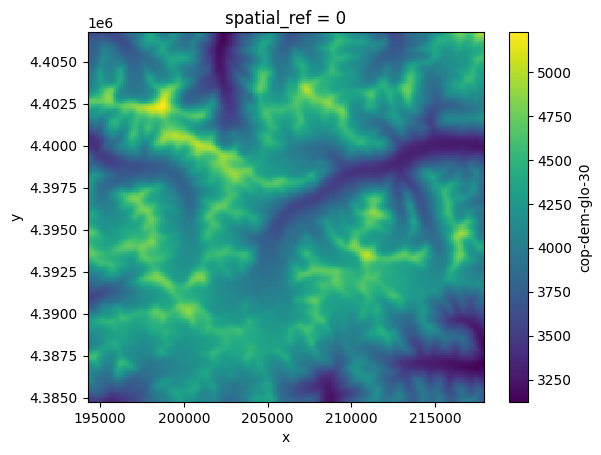

In [116]:
elevation.plot()

In [8]:
dem = data.get_dem_copernicus30(bbox_WSEN)

land_cover = data.get_esa_land_cover(dem)
albedo = data.get_modis_albedo_500m(dem)
emmissivity = data.get_aster_ged_emmis_elev(dem)

rock_glacier_mask = data.get_TPRoGI_rock_glaciers(
    target_dem=dem, dest_dir='./data/rock_glaciers')

glacier_mask = data.get_randolph_glacier_inventory(
    target_dem=dem, dest_dir='./data/glaciers',
)

mask = (glacier_mask.astype(int) + rock_glacier_mask.astype(int) * 2)

spatial_data = xr.merge([
    dem,
    land_cover,
    albedo,
    emmissivity,
    glacier_mask,
    rock_glacier_mask,
    mask.rename('mask'),
])

2025-04-08 11:25:48.200 | INFO     | cryogrid_pytools.data.from_planetary_computer.get_dem_copernicus30:89 | Fetching COP DEM Global data from Planetary Computer (cop-dem-glo-30 @ 30m)
2025-04-08 11:25:49.103 | INFO     | cryogrid_pytools.data.from_planetary_computer.get_esa_land_cover:175 | Fetching ESA World Cover (v2.0) data from Planetary Computer (esa-worldcover @ 30m)
2025-04-08 11:25:52.095 | INFO     | cryogrid_pytools.data.from_earth_engine.get_modis_albedo_500m:48 | Fetching MODIS albedo data from Earth Engine (MODIS/061/MCD43A3 @ 500m)
2025-04-08 11:25:55.033 | INFO     | cryogrid_pytools.data.from_earth_engine.get_aster_ged_100m_v3:102 | Fetching ASTER-GED emissivity data from Earth Engine (NASA/ASTER_GED/AG100_003 @ 100m)
2025-04-08 11:25:57.791 | WARNING  | cryogrid_pytools.data.shapefiles.get_TPRoGI_rock_glaciers:100 | No rock glaciers found in the bounding box.
2025-04-08 11:26:00.494 | INFO     | cryogrid_pytools.data.shapefiles.get_randolph_glacier_inventory:40 | RGI:

In [10]:
spatial_data

<xarray.Dataset> Size: 34MB
Dimensions:                         (x: 790, y: 732, band: 5)
Coordinates: (12/21)
  * x                               (x) float64 6kB 1.943e+05 ... 2.18e+05
  * y                               (y) float64 6kB 4.407e+06 ... 4.385e+06
    spatial_ref                     int64 8B 0
    created                         <U27 108B '2022-10-21T07:35:40.236136Z'
    grid:code                       <U21 84B 'ESAWORLDCOVER-N39E069'
    esa_worldcover:product_tile     <U7 28B 'N39E069'
    ...                              ...
    end_datetime                    <U20 80B '2021-12-31T23:59:59Z'
    proj:code                       <U9 36B 'EPSG:4326'
    platform                        <U50 200B 'sentinel-1a, sentinel-1b, sent...
    title                           <U18 72B 'Land Cover Classes'
  * band                            (band) int64 40B 10 11 12 13 14
    band_center                     (band) float64 40B 8.3 8.65 9.1 10.6 11.3
Data variables:
    cop_dem_glo_30                  (y, x) float64 5MB dask.array<chunksize=(730, 788), meta=np.ndarray>
    esa_world_cover                 (y, x) float64 5MB 60.0 100.0 ... 100.0
    modis_albedo_BSA_shortwave      (y, x) float64 5MB 0.118 0.118 ... 0.106
    aster_elevation                 (y, x) float32 2MB 3.641e+03 ... 3.777e+03
    aster_emissivity                (band, y, x) float32 12MB 0.97 ... 0.9605
    glaciers_RGI                    (y, x) bool 578kB False False ... False
    rock_glaciers_TPRoGI            (y, x) bool 578kB dask.array<chunksize=(730, 788), meta=np.ndarray>
    mask                            (y, x) int64 5MB dask.array<chunksize=(730, 788), meta=np.ndarray>
Attributes:
    smoothing_kernel:       box_kernel
    smoothing_kernel_size:  3
    smoothing_iterations:   2
    source:                 https://planetarycomputer.microsoft.com/api/stac/...
    bbox_request:           (71.44175183508192, 39.565609290405106, 71.708237...